In [1]:
import pandas as pd
import yfinance as yf 
from datetime import datetime
from datetime import timedelta
from Moving_Stock_Data import create_stock_df
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
#ALL STATIC DATA FILES FROM DIFFERENT COMPANIES ON FEB 26TH
aapldata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_aapl2020226731.txt',names=['lastSaleTime','lastSalePrice'])
disdata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_Dis2020226731.txt',names=['lastSaleTime','lastSalePrice'])
amzndata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_amzn2020226731.txt',names=['lastSaleTime','lastSalePrice'])
badata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_ba2020226730.txt',names=['lastSaleTime','lastSalePrice'])
bpdata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_bp2020226731.txt',names=['lastSaleTime','lastSalePrice'])
xdata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_x2020226730.txt',names=['lastSaleTime','lastSalePrice'])
chtrdata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_chtr2020226731.txt',names=['lastSaleTime','lastSalePrice'])
ctldata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_ctl2020226730.txt',names=['lastSaleTime','lastSalePrice'])
dukdata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_duk2020226730.txt',names=['lastSaleTime','lastSalePrice'])   
foxadata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_foxa2020226731.txt',names=['lastSaleTime','lastSalePrice'])
gedata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_ge2020226731.txt',names=['lastSaleTime','lastSalePrice'])
googdata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_goog2020226730.txt',names=['lastSaleTime','lastSalePrice'])
jpmdata = pd.read_csv(r'https://raw.githubusercontent.com/AlpineMeadow/M567-Class-Project/master/StockPrice_jpm2020226730.txt',names=['lastSaleTime','lastSalePrice'])


In [3]:
#put dataframes into list and put their abbreviations in a list
#be careful to line them up together correctly


datalist=[aapldata,disdata,amzndata,badata,bpdata,xdata,chtrdata,ctldata,dukdata,foxadata,gedata,googdata,jpmdata]

companies=['AAPL','DIS','AMZN','BA','BP','X','CHTR','CTL','DUK','FOXA','GE','GOOG','JPM']

In [4]:

days_used=10 #number of previous day's data used to create bounds
test_date='2020-02-26' 

stock_df = create_stock_df(companies,days_used,test_date)   #uses yfinance to get our historical data for 
                                                            #all companies in our list
#Multi-indexed dataframe
#The outer columns are Adj. Close, Close, High, Low, Open, Volume
#Inner columns are company abbreviations in all caps
#stock_df['Close']['AAPL'] will give you dataframe of all of Apple's closing prices for the last 'days_used'

    
max_stock_df = stock_df.max() #gets the max of all values for each category in our dataframe
min_stock_df = stock_df.min() #gets the min of all values for each category in our dataframe

[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  13 of 13 completed


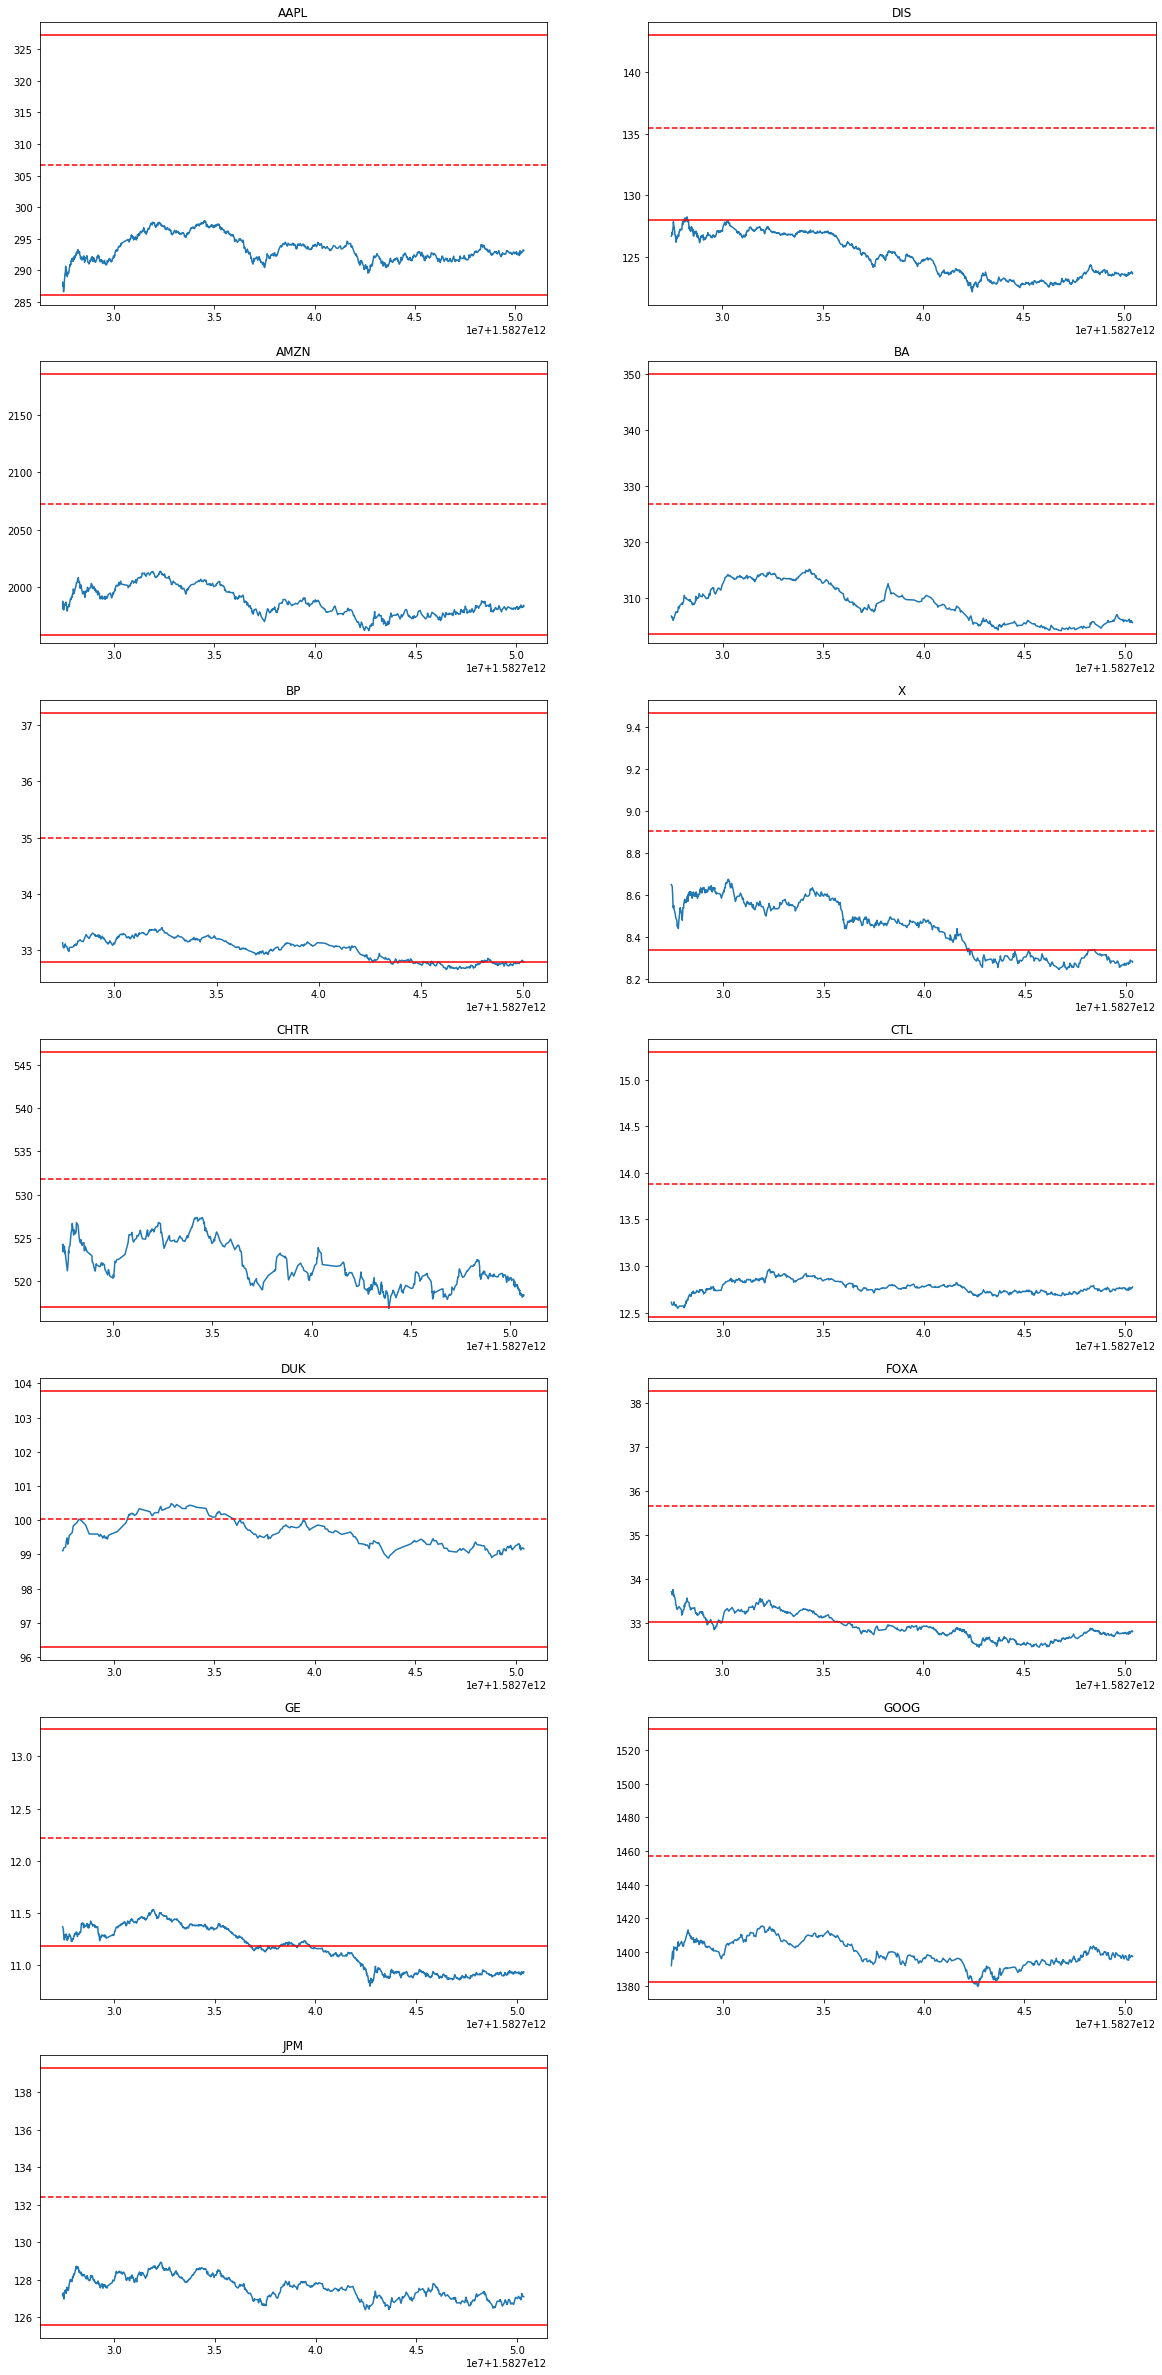

In [5]:
#Not relevant when working with streaming data
#Plots our static data files along with their bounds

plt.figure(figsize=(20,80))
for i in range(len(datalist)):
    company=companies[i]
    xplot=datalist[i]['lastSaleTime']
    yplot=datalist[i]['lastSalePrice']
    maxval = max_stock_df['High'][company]
    minval = min_stock_df['Low'][company]
    middle=(maxval+minval)/2
    plt.subplot(len(datalist),2,i+1)
    plt.plot(xplot,yplot)
    plt.axhline(y=maxval, color='r', linestyle='-')
    plt.axhline(y=minval, color='r', linestyle='-')
    plt.axhline(y=middle, color='r', linestyle='--')
    plt.title(company)


In [6]:
#this loop gives us lists of companies that opened the day within their bounds, all others are thrown out for the day
trading_companies=[]
trading_data=[]
for i in range(len(datalist)):
    open_price=datalist[i].iloc[0]['lastSalePrice']
    max_val=max_stock_df['High'][companies[i]]
    min_val=min_stock_df['Low'][companies[i]]
    if open_price > min_val and open_price<max_val:
        trading_companies.append(companies[i])
        trading_data.append(datalist[i])
    else:
        pass

In [7]:
#Create arrays of max and min values so their index cooresponds to the correct company's index in our 'companies' list
max_list=[max_stock_df['High'][trading_companies[i]] for i in range(len(trading_companies))]
max_arr=np.array(max_list)
min_list=[min_stock_df['Low'][trading_companies[i]] for i in range(len(trading_companies))]
min_arr=np.array(min_list)

In [10]:
wallet=10000
drop_threshold=0.002 #If price falls below min_value - drop_threshold*min_value we stop trading that company for today
buy_threshold=0.002 #Price needs to be within min_value +- buy_threshold for us to consider buying
assets=np.zeros(len(trading_companies)) #Initialize our asset wallet with zeros

tracker=0 
 
currentcompany='na' #initialize what company we are currently holding

for i in range(1,len(aapldata)):
    currentprices=[trading_data[j].iloc[i]['lastSalePrice'] for j in range(len(trading_data))]
    currentprices=np.array(currentprices)
    
    # We will remove any companies that fall below their minimum bound
    
    del_these = np.where(currentprices<min_arr-drop_threshold*min_arr)[0]
    
    if len(del_these)!=0:  
        for index in sorted(del_these, reverse=True):
            wallet+=sum(currentprices[del_these]*assets[del_these]) #sell any shares to companies we are throwing out
            del trading_companies[index]
            del trading_data[index]
            max_arr = np.delete(max_arr,[index])
            min_arr = np.delete(min_arr,[index])
            currentprices = np.delete(currentprices,[index])
            assets = np.delete(assets,[index])
            break
    else:
        pass

    lower_proximity=(currentprices-min_arr)/min_arr
    lower_proximity=np.abs(lower_proximity)
    idx=np.where(lower_proximity == np.amin(lower_proximity))[0][0]
    buy_this=trading_companies[idx]
    
    if np.amin(lower_proximity)<buy_threshold:
        if currentcompany!=buy_this:
            if wallet!=0:
                assets[idx]=wallet/currentprices[idx]
                wallet=0
                previous_idx=idx
            else:
                previous_idx=np.argmax(assets)
                wallet+=assets[previous_idx]*currentprices[previous_idx]
                assets[previous_idx]=0
                assets[idx]=wallet/currentprices[idx]
                wallet=0
               
        else:
            pass
        currentcompany=buy_this
    else:
        pass


    print(assets)
    

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.        

[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0. 

[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0. 

  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.    

  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.    

  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.    

  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.    

[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0. 

[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0. 

  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.    

[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0.       ]
[34.8894006  0.         0.         0.         0.         0.
  0.         0. 

 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.32172562 0.        ]
[0.         0.         0.         0.         0.         0.
 7.3

 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.36087904 0.        ]
[0.         0.         0.         0.         0.         0.
 7.3

  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.
  0.      ]
[ 0.        0.        0.       19.795384  0.        0.        0.

  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.

  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.
  0.          0.        ]
[ 0.          0.         33.72811997  0.          0.          0.

In [11]:
final_idx=np.argmax(assets)
todays_haul = assets[final_idx]*currentprices[final_idx]
todays_haul

10307.313463506627